In [1]:
import numpy as np
from scipy.interpolate import interp1d
from simpegEM1D import EM1DAnalytics
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from simpegEM1D import transFiltImpulse, transFilt, setFrequency, HzanalCirc
from scipy.constants import mu_0
from scipy.interpolate import interp1d
from scipy.signal import butter, freqz

def butterworth_type_filter(frequency, highcut_frequency, order=2):
    """
    Butterworth low pass filter

    Parameters
    ----------

    highcut_frequency: float
        high-cut frequency for the low pass filter
    fs: float
        sampling rate, 1./ dt, (default = 1MHz)
    period:
        period of the signal (e.g. 25Hz base frequency, 0.04s)
    order: int
        The order of the butterworth filter

    Returns
    -------

    frequency, h: ndarray, ndarray
        Filter values (`h`) at frequencies (`frequency`) are provided.
    """

    # Nyquist frequency
    h = 1./(1+1j*(frequency/highcut_frequency))**order
    return h

def butter_lowpass(highcut_frequency, fs=1e7, period=0.04, order=1):
    """
    Butterworth low pass filter
    
    Parameters
    ----------
    
    highcut_frequency: float
        high-cut frequency for the low pass filter
    fs: float
        sampling rate, 1./ dt, (default = 1MHz) 
    period: 
        period of the signal (e.g. 25Hz base frequency, 0.04s)
    order: int
        The order of the butterworth filter
    
    Returns
    -------
    
    frequency, h: ndarray, ndarray
        Filter values (`h`) at frequencies (`frequency`) are provided.
    """
    # Nyquist frequency
    nyq = 0.5 * fs
    n_samples = period * fs    
    high = highcut_frequency / nyq
    b, a = butter(order, high, btype='low')
    w, h = freqz(b, a, worN=int(n_samples))
    frequency = (fs * 0.5 / np.pi) * w
    
    return frequency, h

def dBzdtAnalCircTCole(a, t, sigma, highcut_frequency=None):

    wt, tbase, omega_int = setFrequency(t)
    hz = HzanalCirc(sigma, omega_int/2/np.pi, 1., a, 'secondary')
    # Treatment for inaccuracy in analytic solutions
    ind = omega_int < 0.2
    hz[ind] = 0.
    if highcut_frequency is not None:
#         frequency, values = butter_lowpass(highcut_frequency)
#         lowpass_func = interp1d(frequency*2*pi, values, fill_value='extrapolate')
#         lowpass_filter = lowpass_func(omega_int)
        lowpass_filter = butterworth_type_filter(omega_int/(2*np.pi), highcut_frequency, order=2)
        lowpass_filter *= butterworth_type_filter(omega_int/(2*np.pi), 300*1e3, order=1)
        hz *= lowpass_filter*lowpass_filter
        
    dhzdtTD = -transFiltImpulse(hz, wt, tbase, omega_int, t)
    lowpass_resp = -transFiltImpulse(lowpass_filter, wt, tbase, omega_int, t)    

    return dhzdtTD*mu_0, lowpass_resp

In [3]:
freq, h = butter_lowpass(2e5)

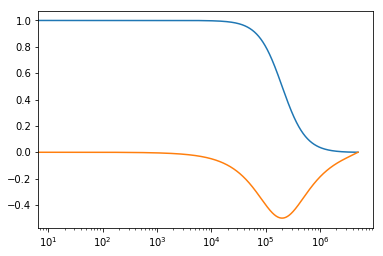

In [4]:
plt.semilogx(freq, h.real)
plt.semilogx(freq, h.imag)

In [5]:
time = np.logspace(-5, -2, 61)

In [6]:
sigma = 1e-2

In [7]:
out_temp, filter_temp = dBzdtAnalCircTCole(13., time, sigma, highcut_frequency=210*1e3)

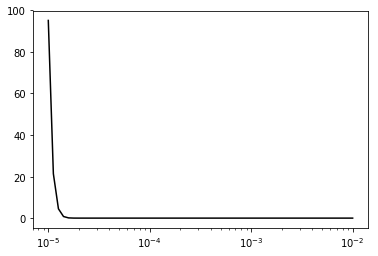

In [8]:
plt.semilogx(time, -filter_temp, 'k')

In [9]:
sigma = 1e-3
out_lowpass_10k,_ = dBzdtAnalCircTCole(13., time, sigma, highcut_frequency=1e4)
out_lowpass_70k,_ = dBzdtAnalCircTCole(13., time, sigma, highcut_frequency=7e4)
out_lowpass_100k,_ = dBzdtAnalCircTCole(13., time, sigma, highcut_frequency=1e5)
out_lowpass_210k,_ = dBzdtAnalCircTCole(13., time, sigma, highcut_frequency=210*1e3)
# out, _ = dBzdtAnalCircTCole(13., time, sigma, highcut_frequency=None)

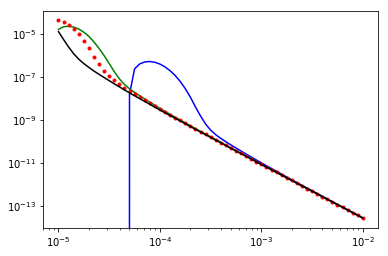

In [10]:
# plt.loglog(time, -out, 'k-', lw=4)
plt.loglog(time, -out_lowpass_10k, 'b')
plt.loglog(time, -out_lowpass_70k, 'g')
plt.loglog(time, -out_lowpass_100k, 'r.')
plt.loglog(time, -out_lowpass_210k, 'k')